In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [26]:
df = pd.read_csv('weather_data.csv')

In [27]:
df = pd.DataFrame(df)

In [28]:
df.head(5)

,time,temp,wind_speed,wind_degree,pressure,precip,humidity,cloud,uv,weather
0,2024-11-01 00:00,26.2,4.7,180,29.82,0.0,76,80,0.0,1063
1,2024-11-01 01:00,26.0,5.4,192,29.81,0.0,75,76,0.0,1063
2,2024-11-01 02:00,26.0,5.0,207,29.79,0.0,75,17,0.0,1000
3,2024-11-01 03:00,25.8,6.1,212,29.79,0.0,75,16,0.0,1000
4,2024-11-01 04:00,25.7,5.8,207,29.81,0.0,75,14,0.0,1000


In [29]:
df.duplicated().sum()

0

In [30]:
training = df.drop(['time', 'weather', 'precip', 'uv'], axis=1)

In [31]:
training.head(5)

,temp,wind_speed,wind_degree,pressure,humidity,cloud
0,26.2,4.7,180,29.82,76,80
1,26.0,5.4,192,29.81,75,76
2,26.0,5.0,207,29.79,75,17
3,25.8,6.1,212,29.79,75,16
4,25.7,5.8,207,29.81,75,14


In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(training)

In [33]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# train_scaled = scaler.fit_transform(training)

In [34]:
pd.DataFrame(train_scaled).head(5)

,0,1,2,3,4,5
0,0.304348,0.217172,0.501393,0.653846,0.612245,0.791667
1,0.286957,0.252525,0.534819,0.615385,0.591837,0.750000
2,0.286957,0.232323,0.576602,0.538462,0.591837,0.135417
3,0.269565,0.287879,0.590529,0.538462,0.591837,0.125000
4,0.260870,0.272727,0.576602,0.615385,0.591837,0.104167


In [35]:
def create_sequences(data, sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon):
        X.append(data[i:i + sequence_length, :])
        y.append(data[i + sequence_length:i + sequence_length + forecast_horizon, :])
        
    return np.array(X), np.array(y)

In [36]:
sequence_length = 6
forecast_horizon = 1

X, y = create_sequences(train_scaled, sequence_length, forecast_horizon)

In [37]:
split_ratio = 0.8
split = int(split_ratio * len(X))

x_train, x_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [72]:
num_features = X.shape[2]

model = tf.keras.Sequential([    
    tf.keras.layers.Input(shape=(sequence_length, num_features)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(192, return_sequences=False)),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(192, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(num_features * forecast_horizon),  
    tf.keras.layers.Reshape((forecast_horizon, num_features))
])

model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9), loss='mae', metrics=['mae'])

In [73]:
init_weights = model.get_weights()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 6, 512)           405504    
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 6, 512)           2048      
 ormalization)                                                   
                                                                 
 bidirectional_1 (Bidirectio  (None, 384)              813312    
 nal)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 384)              1536      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 128)               4

In [74]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor = 0.5, patience=4, min_lr=1e-6)

In [75]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs):
        if logs['mae'] <= 0.058 and logs['val_mae'] <= 0.060:
            self.model.stop_training = True

custom_early_stopping = CustomEarlyStopping()

In [76]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [77]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, verbose=1, callbacks=[custom_early_stopping])
# history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, verbose=1, callbacks=[reduce_lr])

Epoch 1/100
37/37 [==============================] - 11s 136ms/step - loss: 5.6118 - mae: 0.2194 - val_loss: 5.3762 - val_mae: 0.3517
Epoch 2/100
37/37 [==============================] - 2s 53ms/step - loss: 4.8002 - mae: 0.1262 - val_loss: 4.6201 - val_mae: 0.3023
Epoch 3/100
37/37 [==============================] - 3s 69ms/step - loss: 4.1152 - mae: 0.0985 - val_loss: 3.9799 - val_mae: 0.2685
Epoch 4/100
37/37 [==============================] - 2s 61ms/step - loss: 3.5443 - mae: 0.0914 - val_loss: 3.4361 - val_mae: 0.2448
Epoch 5/100
37/37 [==============================] - 1s 37ms/step - loss: 3.0567 - mae: 0.0869 - val_loss: 2.9652 - val_mae: 0.2197
Epoch 6/100
37/37 [==============================] - 1s 39ms/step - loss: 2.6361 - mae: 0.0809 - val_loss: 2.5652 - val_mae: 0.2027
Epoch 7/100
37/37 [==============================] - 1s 38ms/step - loss: 2.2766 - mae: 0.0773 - val_loss: 2.2233 - val_mae: 0.1895
Epoch 8/100
37/37 [==============================] - 2s 42ms/step - loss: 

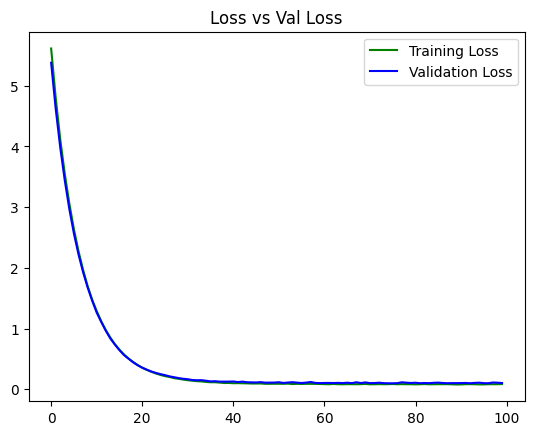

In [78]:
plt.plot(history.history['loss'], color='g', label='Training Loss')
plt.plot(history.history['val_loss'], color='b', label='Validation Loss')
plt.title("Loss vs Val Loss")
plt.legend()
plt.show()

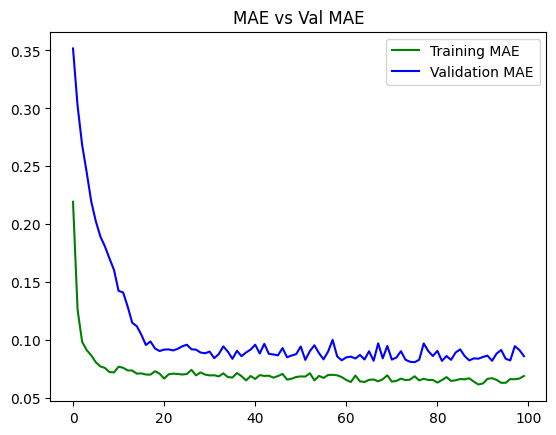

In [79]:
plt.plot(history.history['mae'], color='g', label='Training MAE')
plt.plot(history.history['val_mae'], color='b', label='Validation MAE')
plt.title("MAE vs Val MAE")
plt.legend()
plt.show()

In [80]:
loss, mae = model.evaluate(x_test, y_test, verbose=0)
print("Loss : {}, MAE : {}".format(loss, mae))

Loss : 0.1039479523897171, MAE : 0.08611676841974258


In [81]:
predictions = model.predict(x_test)

print(scaler.inverse_transform(predictions[2]))
print(scaler.inverse_transform(y_test[2]))

5/5 [==============================] - 1s 15ms/step
[[ 26.176725    2.6323898 165.81602    29.781328   79.80605    68.93578  ]]
[[ 26.6    3.6  155.    29.79  79.    41.  ]]


In [82]:
# model.save('forecasting.h5')